# Yearbook Photo Grid Detection Using Amazon Nova 2 Lite

This notebook demonstrates how to use **Amazon Nova 2 Lite** to detect individual portrait photos in yearbook grid layouts.

Based on the official [Amazon Nova - Developer Guide for Amazon Nova 2](https://docs.aws.amazon.com/pdfs/nova/latest/nova2-userguide/nova2-ug.pdf):

> Amazon Nova 2 models provide the ability to identify objects and their positions within images, a task sometimes referred to as image grounding or object localization. Regardless of the image input resolution and aspect ratio, the model uses a coordinate space that divides the image into 1,000 units horizontally and 1,000 units vertically, with the x:0 y:0 location being the upper left of the image. Bounding boxes are described using the format `[x1, y1, x2, y2]` representing left, top, right and bottom respectively.

**Recommended inference parameters for object detection:**
- `temperature: 0`
- Do not enable reasoning

By the end of this notebook, you'll be able to:
* Upload yearbook page images
* Detect individual portraits using Amazon Nova 2 Lite
* Get accurate bounding boxes for each photo
* Visualize detection results with overlays

## Setup

Install required libraries and import dependencies.

In [1]:
!pip install boto3 pillow matplotlib --quiet

In [2]:
import boto3
import json
import base64
import re
import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from textwrap import dedent

Configure the Amazon Nova 2 Lite model. Ensure you have access to the model in your AWS region.

In [3]:
bedrock_runtime = boto3.client("bedrock-runtime", region_name="us-east-1")
MODEL_ID = "us.amazon.nova-2-lite-v1:0"

Verify model access.

In [4]:
try:
    response = bedrock_runtime.invoke_model(
        modelId=MODEL_ID,
        body=json.dumps({
            "messages": [{ "role": "user", "content": [ {"text": "Hello"} ] } ] }),
        contentType='application/json',
        accept='application/json'
    )
    print(f"✅ Model '{MODEL_ID}' is activated and available.")
except Exception as e:
    if "AccessDeniedException" in str(e) or "is not enabled" in str(e):
        print(f"❌ Model '{MODEL_ID}' is not activated.")
        print("🔗 Activate it here: https://console.aws.amazon.com/bedrock/home?modelaccess#/modelaccess")
    else:
        print(f"❌ Error: {e}")

✅ Model 'us.amazon.nova-2-lite-v1:0' is activated and available.


## Load Yearbook Image

Specify the path to your yearbook page image.

In [5]:
# Replace with your yearbook image path
yearbook_image_path = "./sample.jpg"

Helper functions for image processing.

✅ Loaded image: 751x500 pixels


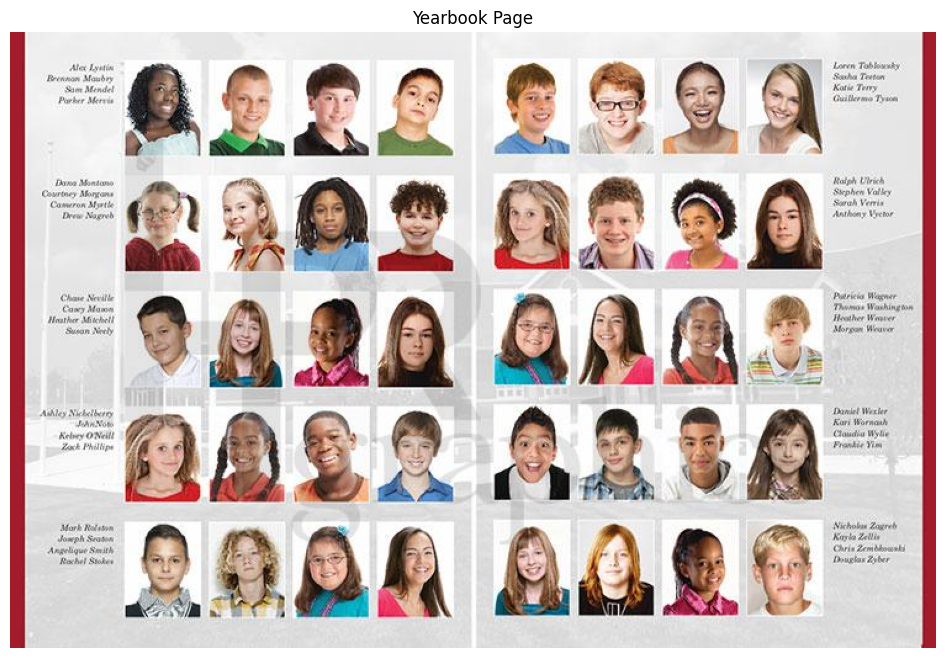

In [6]:
def load_image_as_base64(filepath, max_size=(2048, 2048)):
    """Load and encode image as base64 PNG."""
    img = Image.open(filepath)
    img.thumbnail(max_size, Image.Resampling.LANCZOS)
    
    with io.BytesIO() as output:
        img.save(output, format="PNG")
        png_bytes = output.getvalue()
        base64_str = base64.b64encode(png_bytes).decode("utf-8")
    
    return base64_str, png_bytes, img

# Load yearbook image
base64_image, image_bytes, img = load_image_as_base64(yearbook_image_path)
print(f"✅ Loaded image: {img.size[0]}x{img.size[1]} pixels")

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Yearbook Page")
plt.show()

## Define Detection Litempt

Following the official Nova 2 prompt template for detecting multiple instances with bounding boxes.

From the documentation:
> Please identify {target_description} in the image and provide the bounding box coordinates for each one you detect. Represent the bounding box as the [x1, y1, x2, y2] format, where the coordinates are scaled between 0 and 1000 to the image width and height, respectively.

In [7]:
system_prompt = dedent("""\
    You are an expert at analyzing yearbook layouts and detecting individual portrait photographs.
    
    CRITICAL RULES:
    - Only detect ACTUAL PHOTOGRAPHS containing human faces or upper body portraits
    - DO NOT detect text boxes, name lists, captions, or any text-only regions
    - DO NOT detect decorative elements, logos, or non-photo graphics
    - Each detection MUST contain a visible person's face or upper body
    - Create tight bounding boxes around each photo's frame only
""")

instruction = dedent("""\
    Please identify individual portrait photos (student headshots with visible faces) in the image and provide the bounding box coordinates for each one you detect. Represent the bounding box as the [x1, y1, x2, y2] format, where the coordinates are scaled between 0 and 1000 to the image width and height, respectively.
    
    INCLUDE:
    - Individual portrait photos showing a person's face or upper body
    - Photos that are fully visible and complete within the image
    
    EXCLUDE:
    - Text boxes or name list regions (even if they appear rectangular like photos)
    - Photos that are cropped or cut off at image edges
    - Any adjacent text or names - do NOT include them in the bounding box
    
    Each bounding box should contain exactly ONE face/portrait.
""")

## Invoke Nova 2 Lite for Detection

Using `temperature: 0` as recommended by the documentation for object detection use cases.

In [8]:
def parse_coord_text(text):
    """Parses a model response which uses array formatting ([x, y, ...]) to describe points and bounding boxes.
    Returns an array of tuples.
    
    From Nova 2 documentation.
    """
    pattern = r"\[([^\[\]]*?)\]"
    return [
        tuple(int(x.strip()) for x in match.split(","))
        for match in re.findall(pattern, text)
    ]

def remap_bbox_to_image(bounding_box, image_width, image_height):
    """Remap normalized coordinates (0-1000) to actual image coordinates.
    
    From Nova 2 documentation.
    """
    return [
        bounding_box[0] * image_width / 1000,
        bounding_box[1] * image_height / 1000,
        bounding_box[2] * image_width / 1000,
        bounding_box[3] * image_height / 1000,
    ]

def detect_portraits(image_bytes, instruction, system_prompt):
    """Call Nova 2 Lite to detect portrait photos."""
    request_body = {
        "schemaVersion": "messages-v1",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"image": {"format": "png", "source": {"bytes": base64.b64encode(image_bytes).decode()}}},
                    {"text": instruction}
                ]
            }
        ],
        "system": [{"text": system_prompt}],
        "inferenceConfig": {
            "max_new_tokens": 8000,
            "temperature": 0
        }
    }
    
    try:
        response = bedrock_runtime.invoke_model(
            modelId=MODEL_ID,
            body=json.dumps(request_body)
        )
        model_response = json.loads(response["body"].read())
        print("✅ Detection completed successfully.")
        return model_response
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

def parse_detection_response(model_response):
    """Parse the response and extract bounding boxes using the official parsing method."""
    if not model_response:
        return None
    try:
        raw_text = model_response["output"]["message"]["content"][0]["text"]
        print(f"Raw response:\n{raw_text}\n")
        
        # Use official parsing method from documentation
        bboxes = parse_coord_text(raw_text)
        
        # Filter to only valid bounding boxes (4 coordinates)
        valid_bboxes = [bbox for bbox in bboxes if len(bbox) == 4]
        
        print(f"✅ Detected {len(valid_bboxes)} photos")
        return valid_bboxes
    except Exception as e:
        print(f"❌ Parsing failed: {str(e)}")
        return None

# Run detection
model_response = detect_portraits(image_bytes, instruction, system_prompt)
bboxes = parse_detection_response(model_response)

if bboxes:
    print(f"\nBounding boxes (normalized 0-1000):")
    for i, bbox in enumerate(bboxes):
        print(f"  Photo {i+1}: {bbox}")

✅ Detection completed successfully.
Raw response:
[130, 58, 208, 208], [216, 58, 293, 208], [305, 58, 383, 208], [395, 58, 473, 208], [528, 58, 606, 208], [617, 58, 695, 208], [710, 58, 788, 208], [801, 58, 879, 208], [801, 238, 879, 388], [710, 238, 788, 388], [617, 238, 695, 388], [528, 238, 606, 388], [395, 238, 473, 388], [305, 238, 383, 388], [216, 238, 294, 388], [130, 238, 208, 388], [801, 438, 879, 588], [710, 438, 788, 588], [617, 438, 695, 588], [528, 438, 606, 588], [395, 438, 473, 588], [305, 438, 383, 588], [216, 438, 294, 588], [130, 438, 208, 588], [801, 628, 879, 778], [710, 628, 788, 778], [617, 628, 695, 778], [528, 628, 606, 778], [395, 628, 473, 778], [305, 628, 383, 778], [216, 628, 294, 778], [130, 628, 208, 778], [801, 818, 879, 968], [710, 818, 788, 968], [617, 818, 695, 968], [528, 818, 606, 968], [395, 818, 473, 968], [305, 818, 383, 968], [216, 818, 294, 968], [130, 818, 208, 968].

✅ Detected 40 photos

Bounding boxes (normalized 0-1000):
  Photo 1: (130, 58

## Visualize Detection Results

Draw bounding boxes on the yearbook image using the `remap_bbox_to_image` function from the documentation.

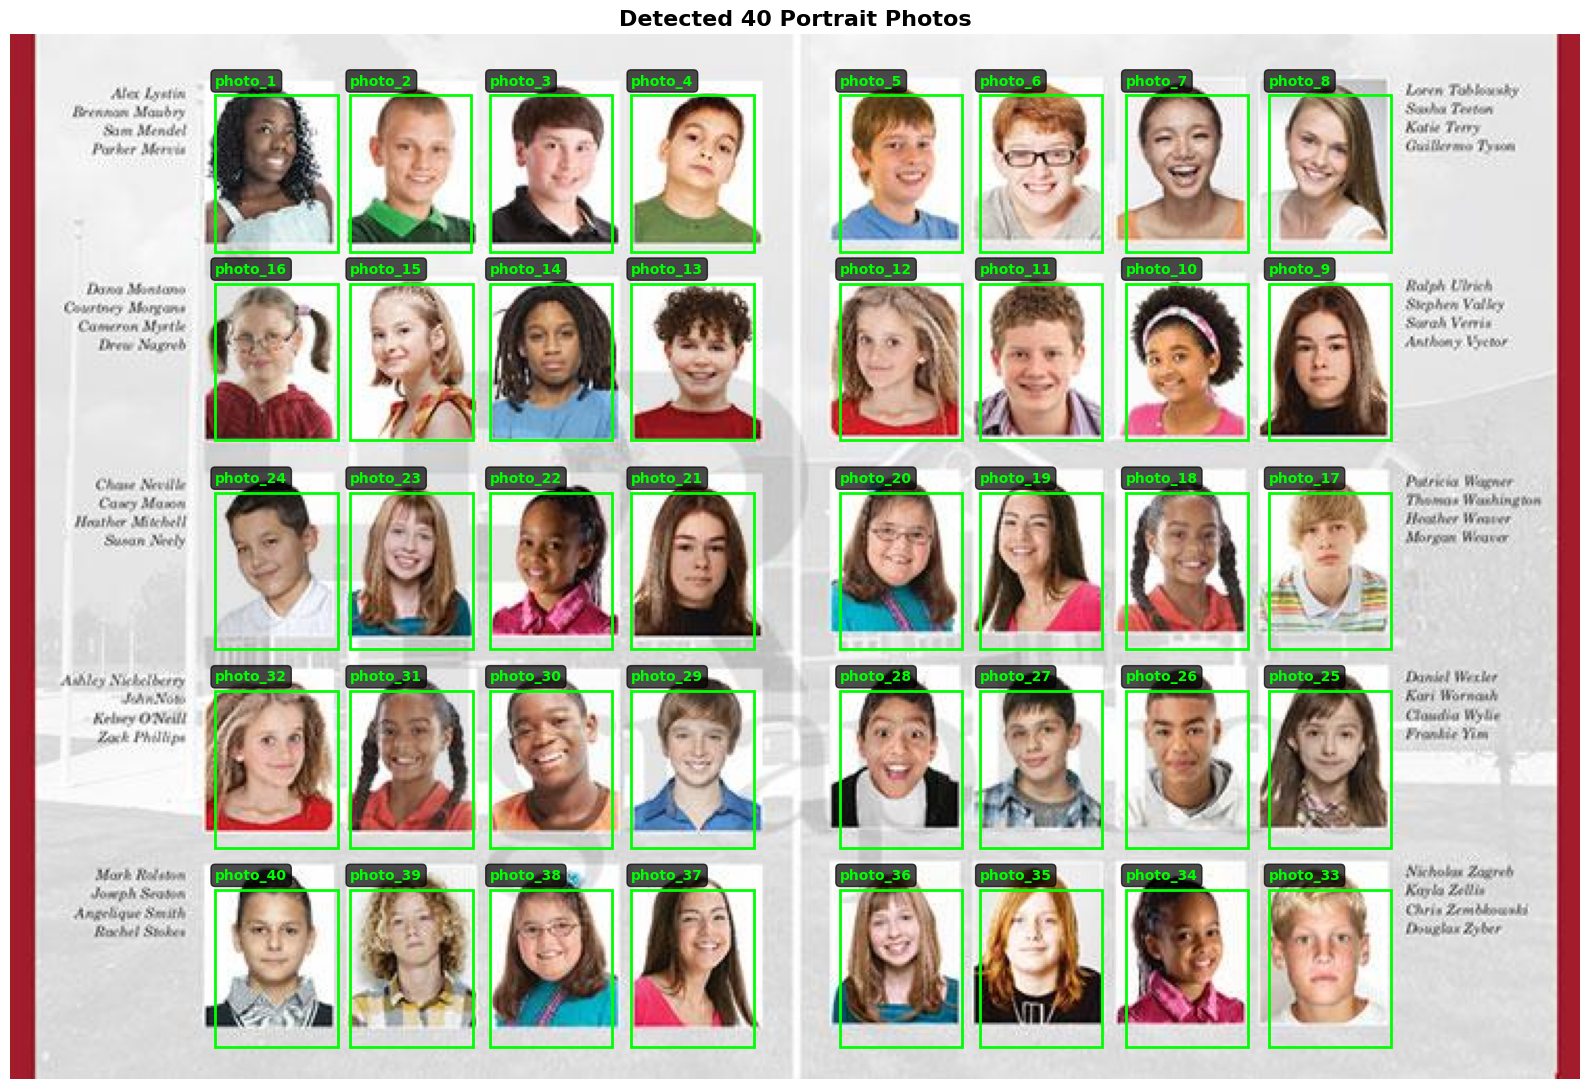

✅ Saved visualization to output.png


In [9]:
def visualize_detections(img, bboxes):
    """Draw bounding boxes on the image."""
    if not bboxes:
        print("No detections to visualize")
        return
    
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(img)
    
    img_width, img_height = img.size
    
    for i, bbox in enumerate(bboxes):
        # Remap from normalized coordinates to image coordinates
        x1, y1, x2, y2 = remap_bbox_to_image(bbox, img_width, img_height)
        
        width = x2 - x1
        height = y2 - y1
        
        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
        
        ax.text(
            x1, y1 - 5,
            f"photo_{i+1}",
            color='lime', fontsize=10, weight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7)
        )
    
    plt.axis('off')
    plt.title(f"Detected {len(bboxes)} Portrait Photos", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.savefig('output.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Saved visualization to output.png")

# Visualize results
if bboxes:
    visualize_detections(img, bboxes)

## Export Bounding Box Coordinates

Save the detection results for downstream processing.

In [10]:
if bboxes:
    img_width, img_height = img.size
    
    # Create structured output
    detection_result = {
        "total_photos": len(bboxes),
        "image_size": {"width": img_width, "height": img_height},
        "photos": [
            {
                "id": f"photo_{i+1}",
                "bbox_normalized": list(bbox),
                "bbox_pixels": remap_bbox_to_image(bbox, img_width, img_height)
            }
            for i, bbox in enumerate(bboxes)
        ]
    }
    
    output_file = "yearbook_detections.json"
    with open(output_file, 'w') as f:
        json.dump(detection_result, f, indent=2)
    print(f"✅ Results saved to {output_file}")
    
    # Print summary
    print(f"\n📊 Detection Summary:")
    print(f"Total photos detected: {detection_result['total_photos']}")
    print(f"\nSample bounding boxes (normalized 0-1000):")
    for photo in detection_result['photos'][:5]:
        bbox = photo['bbox_normalized']
        print(f"  {photo['id']}: [{bbox[0]}, {bbox[1]}, {bbox[2]}, {bbox[3]}]")

✅ Results saved to yearbook_detections.json

📊 Detection Summary:
Total photos detected: 40

Sample bounding boxes (normalized 0-1000):
  photo_1: [130, 58, 208, 208]
  photo_2: [216, 58, 293, 208]
  photo_3: [305, 58, 383, 208]
  photo_4: [395, 58, 473, 208]
  photo_5: [528, 58, 606, 208]
